In [64]:
#pip install pmdarima

READING DATASET:

In [65]:
import pandas as pd

In [66]:
data=pd.read_csv('Documents/AutoScaling/Tasks.csv')
print(data.head())
data.info()

               Process Mem Usage
0  System Idle Process       8 K
1               System     156 K
2             Registry  35,908 K
3             smss.exe   1,116 K
4            csrss.exe   6,628 K
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Process    391 non-null    object
 1   Mem Usage  391 non-null    object
dtypes: object(2)
memory usage: 6.2+ KB


In [67]:
data['Mem Usage'] = data['Mem Usage'].apply(lambda x: x.split(' ')[0])
data.head()


,Process,Mem Usage
0,System Idle Process,8
1,System,156
2,Registry,"35,908"
3,smss.exe,"1,116"
4,csrss.exe,"6,628"


In [68]:
import re
for i in data['Mem Usage']:
    if ',' in i:
        data['Mem Usage']=data['Mem Usage'].apply(lambda x: re.sub(",","",x))
data['Mem Usage']=data['Mem Usage'].apply(lambda x: int(x))
data.head()

,Process,Mem Usage
0,System Idle Process,8
1,System,156
2,Registry,35908
3,smss.exe,1116
4,csrss.exe,6628


FILTERING THE DATASET FOR ENTERED PROCESS:

In [69]:
Entered_process='svchost.exe'
p_prev_records=data[data['Process']==Entered_process]
p_prev_records.head()

,Process,Mem Usage
8,svchost.exe,53544
10,svchost.exe,31212
11,svchost.exe,17672
12,svchost.exe,8236
13,svchost.exe,13488


<AxesSubplot:>

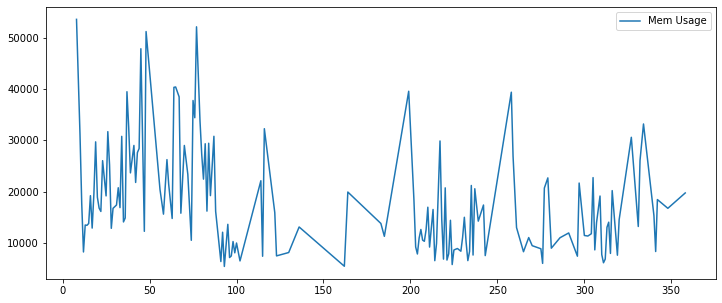

In [70]:
p_prev_records.plot(figsize=(12,5))

TESTING FOR STATIONARY :

In [71]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
    dftest=adfuller(dataset,autolag='AIC')
    print("1. ADF:",dftest[0])
    print("2. p -value:",dftest[1])
    print("3. Num of lags:",dftest[2])
    print("4. No of observations used for ADF_Reg and Critical_val_cal:",dftest[3])
    for key,val in dftest[4].items():
        print("\t",key,":",val)

In [72]:
ad_test(p_prev_records['Mem Usage'])

1. ADF: -2.752666705197325
2. p -value: 0.06535953346036588
3. Num of lags: 5
4. No of observations used for ADF_Reg and Critical_val_cal: 153
	 1% : -3.473829775724492
	 5% : -2.880622899711496
	 10% : -2.5769448985432954


MAKING THE DATASET STATIONARY USING FIRST ORDER DIFFERENCING METHOD:

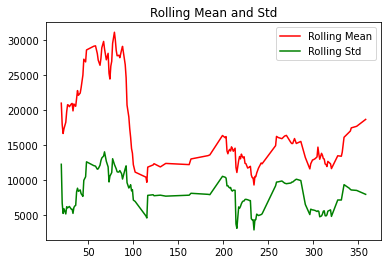

In [73]:
mean = p_prev_records['Mem Usage'].rolling(window=12).mean() 
std =p_prev_records['Mem Usage'].rolling(window=12).std()
import matplotlib.pyplot as plt

mean = plt.plot(mean, color='red', label='Rolling Mean')
std = plt.plot(std, color='green', label='Rolling Std')
# labeling the axis
plt.legend(loc='best')
plt.title('Rolling Mean and Std')
plt.show()
import numpy as np
p_prev_records['Mem Usage'] = np.log( p_prev_records['Mem Usage'])
moving_Average = logScale.rolling(window=12).mean()
moving_STD = logScale.rolling(window=12).std()
plt.plot(logScale)
plt.plot(moving_Average, color='red')
plt.show()

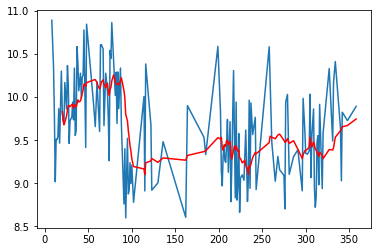

In [74]:
import numpy as np
p_prev_records['Mem Usage'] = np.log( p_prev_records['Mem Usage'])
moving_Average = logScale.rolling(window=12).mean()
moving_STD = logScale.rolling(window=12).std()
plt.plot(logScale)
plt.plot(moving_Average, color='red')
plt.show()

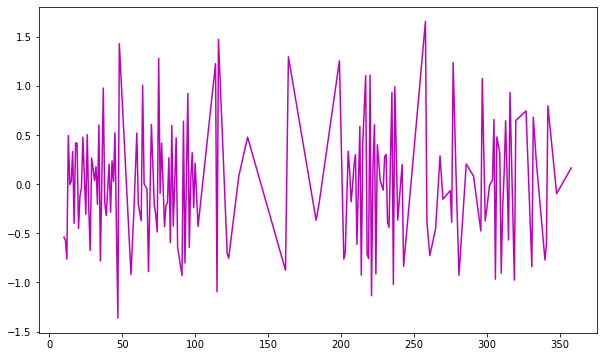

,Process,Mem Usage
8,svchost.exe,NaN
10,svchost.exe,-0.539701
11,svchost.exe,-0.568821
12,svchost.exe,-0.763467
13,svchost.exe,0.493286


In [75]:
plt.figure(figsize=[10, 6])
#  applynig timeshift transformation
p_prev_records['Mem Usage'] = p_prev_records['Mem Usage'] - p_prev_records['Mem Usage'].shift()
# plotting the timeshif 
plt.plot(p_prev_records['Mem Usage'] , c='m')
# showing the timeshift
plt.show()
p_prev_records.head()

In [76]:
p_prev_records["diff_1"] = p_prev_records["Mem Usage"].diff(periods=1)
p_prev_records["diff_2"] = p_prev_records["Mem Usage"].diff(periods=2)
p_prev_records["diff_3"] = p_prev_records["Mem Usage"].diff(periods=3)
p_prev_records.head()

,Process,Mem Usage,diff_1,diff_2,diff_3
8,svchost.exe,NaN,NaN,NaN,NaN
10,svchost.exe,-0.539701,NaN,NaN,NaN
11,svchost.exe,-0.568821,-0.029120,NaN,NaN
12,svchost.exe,-0.763467,-0.194646,-0.223766,NaN
13,svchost.exe,0.493286,1.256752,1.062107,1.032987


AGAIN TESTING FOR STATIONARY:

In [77]:
results = ad_test(p_prev_records["Mem Usage"].dropna())

1. ADF: -9.144725255750282
2. p -value: 2.787819497101088e-15
3. Num of lags: 4
4. No of observations used for ADF_Reg and Critical_val_cal: 153
	 1% : -3.473829775724492
	 5% : -2.880622899711496
	 10% : -2.5769448985432954


<AxesSubplot:>

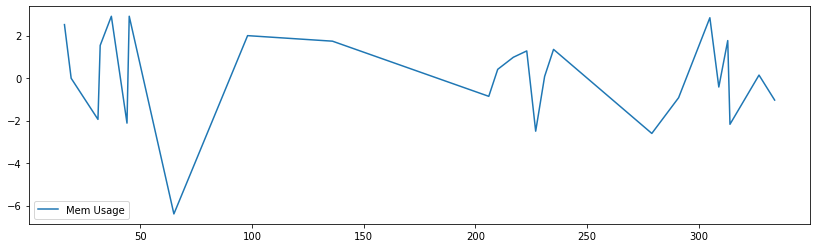

In [97]:
import numpy as np
p_prev_records1 = pd.DataFrame(np.log(p_prev_records["Mem Usage"]).diff().dropna())

p_prev_records1.plot(figsize=(14, 4))

In [98]:
results = adfuller(p_prev_records1)
results[1]

0.027148426920623702

INITIALIZING MODEL :

In [99]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [100]:
stepwise_fit =  auto_arima(p_prev_records1['Mem Usage'],trace=True,supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=113.736, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=110.136, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=111.755, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=109.669, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=110.886, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=107.694, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=108.160, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=108.944, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(3,0

SPILITING DATASET INTO TRAINING AND TESTING SET:

In [101]:
import statsmodels.api as sm

In [102]:
print(p_prev_records1.shape)
train=p_prev_records1.iloc[:-10]
print(train.shape)
test=p_prev_records1.iloc[-10:]
test.shape

(25, 1)
(15, 1)


(10, 1)

TRAINING THE MODEL:

In [103]:
model=sm.tsa.arima.ARIMA(train['Mem Usage'], order=(6,0,2))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Mem Usage   No. Observations:                   15
Model:                 ARIMA(6, 0, 2)   Log Likelihood                 -27.301
Date:                Sat, 18 Feb 2023   AIC                             74.601
Time:                        08:08:44   BIC                             81.682
Sample:                             0   HQIC                            74.526
                                 - 15                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0271      0.079      0.342      0.732      -0.128       0.183
ar.L1         -0.2329      1.017     -0.229      0.819      -2.226       1.760
ar.L2         -0.5241      0.462     -1.134      0.257      -1.430       0.382
ar.L3         -0.4291      0.584     -0.734      0.463      -1.574       0.716
ar.L4         -0.5285      0.727     -0.727      0.467      -1.953       0.896
ar.L5         -0.4757      0.801     -0.594      0.553      -2.046       1.094
ar.L6         -0.4405      0.845     -0.521      0.602      -2.096       1.215
ma.L1         -1.9148    213.790     -0.009      0.993    -420.936     417.107
ma.L2          0.9263    197.369      0.005      0.996    -385.910     387.763
sigma2         0.8129    174.421      0.005      0.996    -341.046     342.672
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 3.22
Prob(Q):                              0.61   Prob(JB):                         0.20
Heteroskedasticity (H):               0.12   Skew:                             1.02
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MODEL PREDICTION ON TEST SET:

In [104]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start, end=end)
print(pred)
print(test)

15   -0.753281
16    0.609898
17    0.101010
18    0.359766
19    0.723924
20    0.834406
21   -0.641321
22   -1.006816
23   -0.287086
24    0.024364
Name: predicted_mean, dtype: float64
     Mem Usage
231   0.076918
235   1.349221
279  -2.603880
291  -0.922835
305   2.838704
309  -0.420256
313   1.763842
314  -2.173753
327   0.140672
334  -1.035081


<AxesSubplot:>

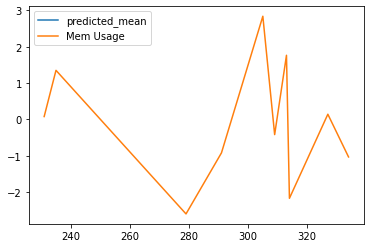

In [105]:
df=pd.DataFrame(pred,index=[320,327,331,332,334,340,358,342,348,341])
df.plot(legend=True)
test['Mem Usage'].plot(legend=True)

EVALUATING THE MODEL :

In [106]:
test['Mem Usage'].mean()

-0.09864482510603088

In [107]:
from sklearn.metrics import mean_squared_error,accuracy_score
from math import sqrt
rmse=sqrt(mean_squared_error(test['Mem Usage'],pred))
print("ERROR :  ",rmse)

ERROR :   1.571487998608836


MODEL PREDICTION FOR CURRENT INSTANCE :

In [113]:
model2=sm.tsa.arima.ARIMA(p_prev_records1['Mem Usage'], order=(6,0,2))
model2=model2.fit()
p_prev_records1.tail()

,Mem Usage
309,-0.420256
313,1.763842
314,-2.173753
327,0.140672
334,-1.035081


In [122]:
pred1=model2.predict(start=len(data),end=len(data),type='levels')
print(pred1)
print(pred1*-(10000))

391   -0.117515
dtype: float64
391    1175.152941
dtype: float64


In [127]:
print('Next Process Takes 1175.15 kb of MEMORY USAGE')

Next Process Takes 1175.15 kb of MEMORY USAGE
